In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from image_extractor import preprocess_hsv, init_lut, linear_fn, curved
from scipy.stats import skew, kurtosis

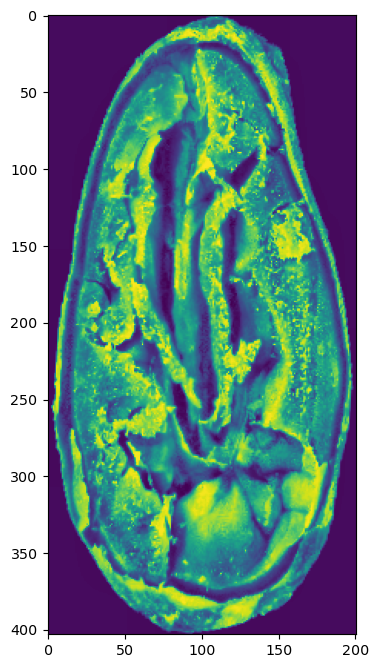

In [4]:
# image_dir  = 'D:/Thesis_data/Backups/Color_Corrected_512x512/Agglutinated/image (78).JPG'
# image_dir  = 'D:/Thesis_data/Backups/Color_Corrected_512x512/Brittle/image (35).JPG'
# image_dir = 'D:/Thesis_data/Backups/Color_Corrected_512x512/Plated_Purple/image (56).JPG'
# image_dir = 'D:/Thesis_data/Backups/Color_Corrected_512x512/Compartmentalized_Purple/image (56).JPG'
# image_dir = 'D:/Thesis_data/Backups/Color_Corrected_512x512/Compartmentalized_White/image (90).JPG'
image_dir = 'D:/Thesis_data/Backups/Color_Corrected_512x512/Compartmentalized_Brown/image (90).JPG'
# image_dir = 'D:/Thesis_data/Backups/Color_Corrected_512x512/Plated_Brown/image (90).JPG'
# image_dir = 'D:/Thesis_data/Backups/Color_Corrected_512x512/Plated_White/image (38).JPG'
# image_dir = 'D:/Thesis_data/Backups/Color_Corrected_512x512/Plated_Slaty/image (71).JPG'
# image_dir = 'D:/Thesis_data/Backups/Color_Corrected_512x512/Compartmentalized_Slaty/image (56).JPG'
# image_dir = 'D:/Thesis_data/Backups/Color_Corrected_512x512/Moldered/image (68).JPG'
image_dir = '/Users/lochuynhquang/Desktop/Color_Corrected_512x512/Compartmentalized_White/image (67).JPG'

plt.rcParams['figure.dpi'] = 102.46
plt.rcParams["figure.figsize"] = (6,6)

lut1 = init_lut(fn=linear_fn, coefficient=15)
lut2 = init_lut(fn=curved, coefficient=1.5)

image = cv2.imread(image_dir)
image_hsv , cnt, ellipse= preprocess_hsv(image, lut1=lut1, lut2=lut2, Contour=True)
image_rgb = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
h,s,v = cv2.split(image_hsv)
clahe_op = cv2.createCLAHE(6, (8,8))
clahe_v = clahe_op.apply(v)
plt.rcParams["figure.figsize"] = (6,8)
plt.imshow(clahe_v)
plt.show()

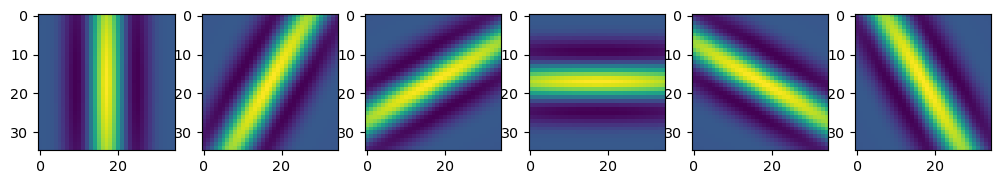

In [6]:
plt.rcParams["figure.figsize"] = (12,6)
gabor_filter = []
theta = [0, np.pi/6,  np.pi/3, np.pi/2, -np.pi/3, -np.pi/6]
for i in range(len(theta)):
    # theta = i*np.pi/4
    gabor_filter.append(cv2.getGaborKernel((35,35), sigma=6, theta=theta[i], lambd=6*np.pi, gamma=0.2, psi=0))
    plt.subplot(1,len(theta),i+1)
    plt.imshow(gabor_filter[i])
plt.show()


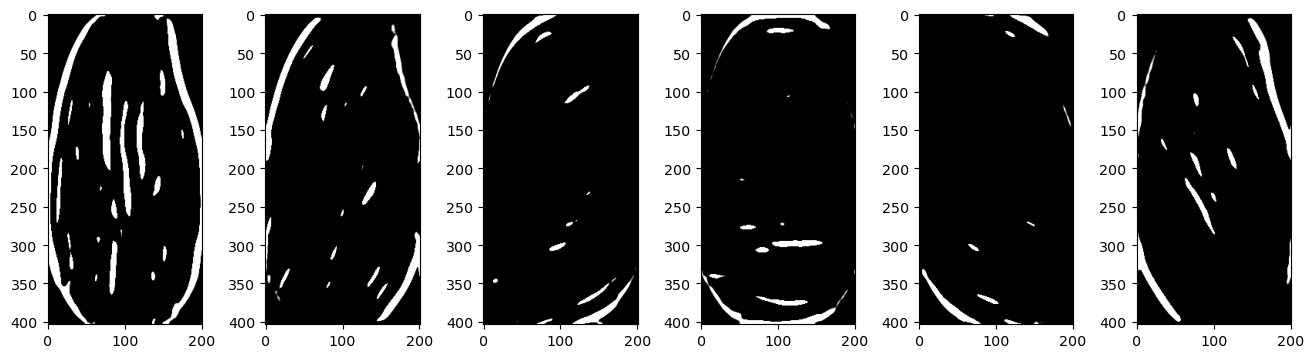

In [10]:
plt.rcParams["figure.figsize"] = (16,4)

gabored = []
for i in range(len(theta)):
    gabored.append(cv2.filter2D(clahe_v, cv2.CV_8UC3, -gabor_filter[i]))
    plt.subplot(1,len(theta),i+1)
    plt.imshow(gabored[i], cmap='gray')
plt.show()

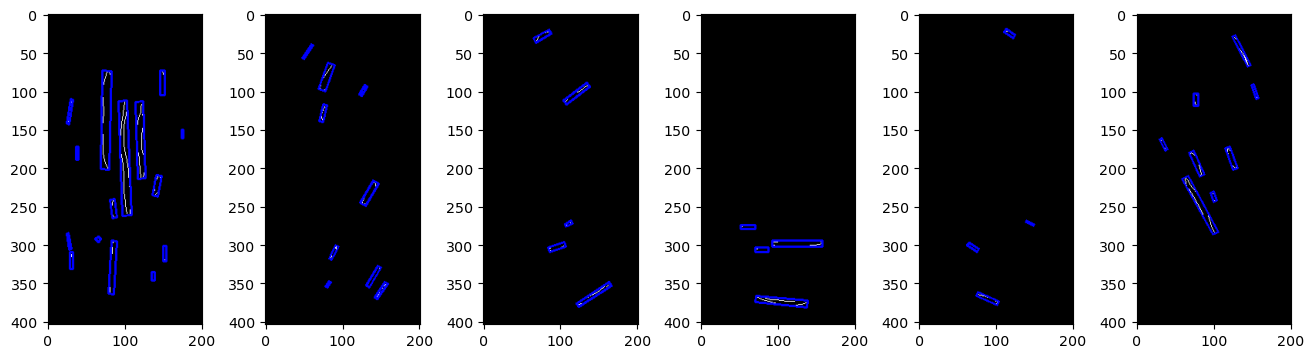

(15, 4)
(9, 4)
(5, 4)
(4, 4)
(4, 4)
(8, 4)


In [12]:
plt.rcParams["figure.figsize"] = (16,4)
bbrect_array = []
for i in range(len(theta)):
    contours, hir = cv2.findContours(gabored[i], cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    hei,wid = np.shape(clahe_v)
    # print('wid=', wid)
    map = np.zeros((hei, wid, 3), dtype=np.uint8)
    bbrect = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if x<20:
            continue
        if (x+w)>(wid-20):
            continue
        if y<20:
            continue
        if (y+h)>(hei-20):
            continue
        convexHull = cv2.convexHull(cnt)
        convexhull_area = cv2.contourArea(convexHull)
        if convexhull_area<16:
            continue
        if len(cnt)<5:
                continue
        if len(convexHull)<5:
                continue
        # (eX, eY), (alX, alY), orientation = cv2.fitEllipse(convexHull)
        cv2.drawContours(map, [cnt], -1, (255, 255, 255), 1)

        rect = cv2.minAreaRect(convexHull)
        (x,y), (w,h), o = rect
        bbrect.append([x,y,w,h])
        box = cv2.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
        box = np.int0(box)
        cv2.drawContours(map,[box],0,(0,0,255),2)
    if len(bbrect) == 0:
        bbrect_array.append([[0,0,0,0]])
    else:
        bbrect_array.append(bbrect)

    plt.subplot(1,len(theta),i+1)
    plt.imshow(map)
plt.show()
# print(n)
for i in range(len(theta)):
    print(np.shape(bbrect_array[i]))



In [22]:
# im = np.zeros((200,200,3), dtype=np.uint8)
# rect1 = ((30,90),(20,50), 45)
# box1 = cv2.boxPoints(rect1)
# rect2 = ((30,90),(20,50), 0)
# box2 = cv2.boxPoints(rect2)
# box1 = np.int0(box1)
# box2 = np.int0(box2)

# cv2.drawContours(im,[box],0,(0,0,255),2)
# cv2.drawContours(im,[box2],0,(0,0,255),2)
# plt.imshow(im)
# plt.show()

In [23]:
n =[]
mean = [] 
std = []
skewness = []
kurtosises = []
for i in range(len(bbrect_array)):
    n.append(np.shape(bbrect_array[i])[0])
    mean.append(np.mean(bbrect_array[i], axis=0).tolist())
    std.append(np.std(bbrect_array[i], axis=0).tolist())
    skewness.append(skew(bbrect_array[i], axis=0).tolist())
    kurtosises.append((-kurtosis(bbrect_array[i], axis=0)).tolist())
print(n)

[11, 5, 1, 1, 1, 4]


In [24]:
print(np.shape(mean))

(6, 4)


In [25]:
print(np.std([0]))

0.0


In [26]:
print(kurtosises)

[[1.0435111549856195, 1.3028237430879257, -5.43799518200716, -0.11902917705101279], [0.9981938320652937, 1.7445836418509069, 1.7043813843204254, 1.6705803526183631], [3.0, 3.0, 3.0, 3.0], [3.0, 3.0, 3.0, 3.0], [3.0, 3.0, 3.0, 3.0], [1.0100501575704193, 1.0363154985547693, 1.4536559340885822, 0.7633397853367039]]
